# PROJET NLP: CLASSIFICATION DE TWEETS

L'objectif de ce projet de dévélopper plusieurs modèles afin de classifier des tweets en trois catégories: haineux(classe 0), offensant(classe 1) et ni l'un ni l'autre(classe 2).

On dispose d'un dataset qui contient plusieurs tweets et les labels correspondants.
La première partie consistera à préparer les donnnées(suppression des caractères inutiles, suppression des stop words, tokenization, lemmatization...)

In [36]:
import pandas as pd 
import numpy as np 
import re 
import spacy

In [3]:
# Données
splits = {'train': 'data/train-00000-of-00001-b57a122b095e5ed1.parquet', 'validation': 'data/validation-00000-of-00001-9ea89a9fc1c6b387.parquet', 'test': 'data/test-00000-of-00001-10d11e25d2e9ec6e.parquet'}
df = pd.read_parquet("hf://datasets/badmatr11x/hate-offensive-speech/" + splits["train"])

In [4]:
print(df.head(15))

    label                                              tweet
0       2  where's his other half??? i want to indulge my...
1       2  easier for barrack hussein obama to blame guns...
2       2  As soon as a Democrat gets a chance to ? the p...
3       1   GOOD Music &gt;&gt;&gt;&gt;&gt; Young Money fags
4       2  mass shooting at orlando gay nightclub: what w...
5       2  @user @user are you guys going to take forever...
6       1                             My niggah my niggah...
7       1  ...and I'm goin back to school.. only for the ...
8       2  @user new music coming! hear a sneak peek now!...
9       2                 actually give my father his gift  
10      2  onerepublic - wherever i go (official video)  ...
11      2  omg yay finally @user @user is finally coming ...
12      2  '#urdu poetry #beutiful #poetry   poetry  #2 l...
13      1                        Sombody bring me some pussy
14      1  RT @JuveUnited: Messi REFUSED to be subbed off...


**Répartition des catégories**

In [5]:
df['label'].value_counts(normalize= True)

label
2    0.597611
1    0.337889
0    0.064500
Name: proportion, dtype: float64

Le jeu de données n'est pas équilibré.
Lors de la phase d'entrainement, nous allons utiliser une séparation stratifiée.

## 1. Préprocessing

**1.1 Suppression des caractères inutiles**

- ***Test du regex***

In [6]:
pattern = r"[^\w\s]"
test = "14 décembre ###@@2024 23h40{@"
re.findall(pattern, test)

['#', '#', '#', '@', '@', '{', '@']

In [7]:
re.sub(pattern, "", test)

'14 décembre 2024 23h40'

- ***Fonction pour supprimer les caractères inutiles***

In [8]:
def remove_characters(text):
    pattern= r"[^\w\s]"
    return re.sub(pattern, "", text)

In [9]:
df['tweet'] = df['tweet'].apply(remove_characters)

In [10]:
print(df.head(7))

   label                                              tweet
0      2  wheres his other half i want to indulge myself...
1      2  easier for barrack hussein obama to blame guns...
2      2  As soon as a Democrat gets a chance to  the po...
3      1             GOOD Music gtgtgtgtgt Young Money fags
4      2  mass shooting at orlando gay nightclub what we...
5      2  user user are you guys going to take forever t...
6      1                                My niggah my niggah


- ***Mettre tout en minuscule***

In [11]:
df['tweet']= df['tweet'].str.lower()

In [12]:
print(df.head(7))

   label                                              tweet
0      2  wheres his other half i want to indulge myself...
1      2  easier for barrack hussein obama to blame guns...
2      2  as soon as a democrat gets a chance to  the po...
3      1             good music gtgtgtgtgt young money fags
4      2  mass shooting at orlando gay nightclub what we...
5      2  user user are you guys going to take forever t...
6      1                                my niggah my niggah


**1. 2 Tokenization**

In [13]:
nlp = spacy.load('en_core_web_lg') # O charge le modèle large pour l'anglais

In [14]:
test = nlp("15 Décembre 00:05")
for word in test: 
    print(word)

15
Décembre
00:05


- ***Fonction pour tokeniser***

In [15]:
def tokanize(text):
    doc = nlp(text)
    return([word.text for word in doc if not word.is_stop and not word.is_punct])

In [16]:
df['tweet'] = df['tweet'].apply(tokanize)

In [17]:
df['tweet'].head(10)

0    [s, half, want, indulge, lot, yunho, esp, danc...
1    [easier, barrack, hussein, obama, blame, guns,...
2    [soon, democrat, gets, chance,  , political, h...
3        [good, music, gtgtgtgtgt, young, money, fags]
4    [mass, shooting, orlando, gay, nightclub, know...
5    [user, user, guys, going, forever, bring, new,...
6                                     [niggah, niggah]
7                       [m, goin, school, hoes, class]
8    [user, new, music, coming, hear, sneak, peek, ...
9                          [actually, father, gift,  ]
Name: tweet, dtype: object

**1.3. Lemmatization**

In [18]:
test = nlp("eat ate eating")
for word in test: 
    print(word)

eat
ate
eating


- ***Fonction pour lemmatizer***

In [19]:
def lemmatize(text):
    doc = nlp(" ".join(text))
    return [word.lemma_ for word in doc]

In [20]:
lemmatize(df['tweet'][0])

['s',
 'half',
 'want',
 'indulge',
 'lot',
 'yunho',
 'esp',
 'dance',
 'head',
 'today',
 '   ',
 'âïðð']

In [21]:
df['tweet'] = df['tweet'].apply(lemmatize)

In [22]:
df['tweet'].head(7)

0    [s, half, want, indulge, lot, yunho, esp, danc...
1    [easy, barrack, hussein, obama, blame, gun, ki...
2    [soon, democrat, get, chance,   , political, h...
3         [good, music, gtgtgtgtgt, young, money, fag]
4    [mass, shoot, orlando, gay, nightclub, know,  ...
5    [user, user, guy, going, forever, bring, new, ...
6                                     [niggah, niggah]
Name: tweet, dtype: object

**1.4 Représentation textuelle**

Pour la representation textuelle, nous allons utiliser un embedding statistique.
On pourrait utiliser un embedding contextuel à l'aide des transformers mais cela est gourmand en calcul.

In [23]:
doc = nlp(" ".join(df['tweet'][0]))
print("Chaque mot est représenté par un vecteur ", str(len(doc.vector)),"*", str(1), "avec l'embedding du modèle en_core_web_sm.")

Chaque mot est représenté par un vecteur  300 * 1 avec l'embedding du modèle en_core_web_sm.


In [24]:
def embedding(text):
    doc = nlp(" ".join(text))
    return doc.vector

In [25]:
df['embedding'] = df['tweet'].apply(embedding)

In [26]:
df['embedding']

0        [1.4436141, 0.96622664, -1.8198816, -1.1180667...
1        [-0.41034362, 1.5116854, -1.7897471, 0.3413112...
2        [0.5144166, 0.9947857, -1.4718955, 0.89902145,...
3        [-0.655965, 0.9352083, -2.674731, -0.46375003,...
4        [-0.0025200183, 1.1542289, -1.8786784, 0.91567...
                               ...                        
51065    [-0.46999636, 1.5054955, -0.14967223, -0.83664...
51066    [1.3609418, 2.1872563, -3.0269845, -0.7565863,...
51067    [0.05848126, 0.3288, -1.8115547, -0.43121278, ...
51068    [-0.12552758, -0.13780001, -0.7453857, 0.07447...
51069    [-0.4855863, 1.4458762, -1.5623549, 0.8310837,...
Name: embedding, Length: 51070, dtype: object

**Train test split**

In [27]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(np.stack(df['embedding'].values), df['label'], train_size= 0.8, stratify= df['label'])

# 2. Le XGBOOST CLASSIFIER

XGBoost (Extreme Gradient Boosting) est un algorithme de machine learning basé sur le boosting, qui combine plusieurs arbres de décision pour améliorer les performances. Il utilise la méthode de gradient boosting, où chaque arbre construit successivement améliore les erreurs des arbres précédents. XGBoost est particulièrement efficace pour les problèmes de régression et de classification, offrant des vitesses d'entraînement rapides, une régularisation pour éviter le sur-apprentissage, et des performances exceptionnelles, surtout avec des données structurées.

**Entrainement**

In [28]:
from xgboost import XGBClassifier

model = XGBClassifier(n_estimators = 200, learning_rate = 0.1, max_depth = 12, min_child_weight= 3)
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=12, max_leaves=None,
              min_child_weight=3, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [29]:
print("Le score sur le train est:", str(model.score(X_train, y_train)))

Le score sur le train est: 0.9984335226160173


In [30]:
model.score(X_test, y_test)

0.8873115331897395

**Evaluation**

In [31]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [32]:
y_pred = model.predict(X_test)

In [33]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.24      0.37       659
           1       0.87      0.89      0.88      3451
           2       0.90      0.96      0.93      6104

    accuracy                           0.89     10214
   macro avg       0.86      0.70      0.73     10214
weighted avg       0.88      0.89      0.87     10214



In [34]:
cm = confusion_matrix(y_test, y_pred)

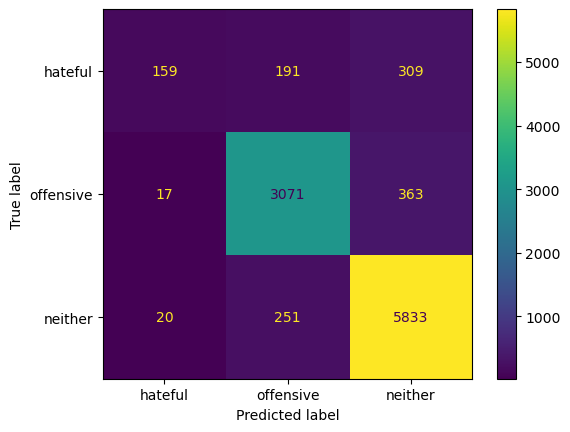

In [35]:
cm_disp = ConfusionMatrixDisplay(confusion_matrix= cm, display_labels= ['hateful','offensive','neither'])
cm_disp.plot()

**ANALYSE DES PERFORMANCES**

**On constate que le modèle peine à avoir de bonnes prédictions sur les tweets catégorisés comme "haineux" étant donné le faible nombre d'exemples.**

- Analyse du score de precision : 
Lorsque le modèle prédit l'une de ces trois classes: on obtient globalement de bonnes prédictions; On peut etre certain qu'à 81% le modèle est correct lorsqu'il catégorise un tweet comme haineux, 87% de précision pour les tweets offensants et 90% de précision pour les autres.

- Analyse du recall:
Le recall est globalement élevé sauf pour la classe 0; Si un tweet est haineux, alors le modèle a 24% de chances d'etre considéré comme telle par le modèle. 
Ce qui est très peu et cela est du au faible nombre d'exemple de tweet haineux dans le modèle.

**La weighted average accuracy(0.87) montre que le modèle prédit globalement bien.**


